# 3. Creación de GTFS específico para el sistema metro

Librerías a utilizar

In [1]:
import os
import pandas as pd
from shapely.geometry import Point, LineString
import geopandas as gpd
import matplotlib.pyplot as plt

Lectura de archivos GTFS

In [2]:
PATH = "../"
data_path = os.path.join(PATH, 'data')
data_files = os.listdir(data_path)

dataframes : dict[pd.DataFrame] = {}
for file in data_files:
    if file.endswith(".txt"):
        datafile_fullpath = os.path.join(data_path, file)
        dataframes[file.split(".")[0]] = pd.read_csv(datafile_fullpath)

Capturamos todas la rutas que sean exclusivamente al sistema metro

In [3]:
list_metro_routes = dataframes["routes"][dataframes["routes"]["agency_id"] == "METRO"]["route_id"].to_list()
list_metro_routes

['CMX0200LB',
 'CMX0200LA',
 'CMX0200L9',
 'CMX0200L8',
 'CMX0200L7',
 'CMX0200L6',
 'CMX0200L5',
 'CMX0200L4',
 'CMX0200L3',
 'CMX0200L2',
 'CMX0200L1',
 'CMX020L12']

Capturamos las rutas y sus colores hexadecimales correspondientes

In [4]:
df_metro_routeid_colors = dataframes["routes"][["route_id", "route_color"]][dataframes["routes"]["route_id"].isin(list_metro_routes)].reset_index().drop(labels = "index", axis = 1)
df_metro_routeid_colors

,route_id,route_color
0,CMX0200LB,118751
1,CMX0200LA,A02D96
2,CMX0200L9,512826
3,CMX0200L8,118749
4,CMX0200L7,E87511
5,CMX0200L6,D81E05
6,CMX0200L5,F9D616
7,CMX0200L4,7FBCAA
8,CMX0200L3,AD9B0C
9,CMX0200L2,0071C1


## Filtrando ```trips.txt```

Filtramos los viajes que contengan a las rutas halladas del metro

In [5]:
index_metro_trips = dataframes["trips"].isin(list_metro_routes).any(axis = 1)

Obtenemos el dataframe asociado a los viajes (trips)

In [6]:
df_metro_trips = dataframes["trips"][index_metro_trips].reset_index().drop(labels = "index", axis = 1)
df_metro_trips.to_csv("../output_metro/trips_metro.csv", index = False)
df_metro_trips

,route_id,service_id,trip_id,trip_headsign,trip_short_name,direction_id,shape_id
0,CMX0200L2,3,02300L2000_1,Cuatro Caminos,Línea 2 to Cuatro Caminos,1,SH0200L2000_1
1,CMX0200L2,3,02300L2000_0,Tasqueña,Línea 2 to Tasqueña,0,SH0200L2000_0
2,CMX0200L2,2,02200L2000_1,Cuatro Caminos,Línea 2 to Cuatro Caminos,1,SH0200L2000_1
3,CMX0200L2,2,02200L2000_0,Tasqueña,Línea 2 to Tasqueña,0,SH0200L2000_0
4,CMX0200L2,1,02100L2000_1,Cuatro Caminos,Línea 2 to Cuatro Caminos,1,SH0200L2000_1
...,...,...,...,...,...,...,...
67,CMX020L12,3,0230L12000_0,Tláhuac,to Tláhuac,0,SH020L12000_0
68,CMX020L12,2,0220L12000_1,Mixcoac,to Mixcoac,1,SH020L12000_1
69,CMX020L12,2,0220L12000_0,Tláhuac,to Tláhuac,0,SH020L12000_0
70,CMX020L12,1,0210L12000_1,Mixcoac,to Mixcoac,1,SH020L12000_1


Contando con la información de los viajes, se podrá cruzar la información de las rutas y su color asociado con sus respectivos shape_id

In [7]:
df_metro_shapeid_colors = pd.merge(df_metro_trips, df_metro_routeid_colors, on = "route_id", how = "left")
df_metro_shapeid_colors = df_metro_shapeid_colors[["shape_id", "route_color"]].drop_duplicates()

dict_metro_shapeid_colors = {}
for index, row in df_metro_shapeid_colors.iterrows():
    dict_metro_shapeid_colors[row["shape_id"]] = "#" + row["route_color"]
dict_metro_shapeid_colors

{'SH0200L2000_1': '#0071C1',
 'SH0200L2000_0': '#0071C1',
 'SH0200L3000_1': '#AD9B0C',
 'SH0200L3000_0': '#AD9B0C',
 'SH0200L4000_1': '#7FBCAA',
 'SH0200L4000_0': '#7FBCAA',
 'SH0200L5000_1': '#F9D616',
 'SH0200L5000_0': '#F9D616',
 'SH0200L6000_1': '#D81E05',
 'SH0200L6000_0': '#D81E05',
 'SH0200L7000_1': '#E87511',
 'SH0200L7000_0': '#E87511',
 'SH0200L8000_1': '#118749',
 'SH0200L8000_0': '#118749',
 'SH0200L9000_1': '#512826',
 'SH0200L9000_0': '#512826',
 'SH0200LA000_1': '#A02D96',
 'SH0200LA000_0': '#A02D96',
 'SH0200LB000_1': '#118751',
 'SH0200LB000_0': '#118751',
 'SH0200L1000_1': '#F94F8E',
 'SH0200L1000_0': '#F94F8E',
 'SH020L12000_1': '#B99E51',
 'SH020L12000_0': '#B99E51'}

## Filtrando ```shapes.txt```

Obtenemos el dataframe asociado al trazo en el mapa de las rutas (shapes)

In [8]:
list_metro_shapes = df_metro_trips["shape_id"].drop_duplicates().to_list()
index_metro_shapes = dataframes["shapes"].isin(list_metro_shapes).any(axis = 1)

df_metro_shapes = dataframes["shapes"][index_metro_shapes].reset_index().drop(labels = "index", axis = 1)
df_metro_shapes.to_csv("../output_metro/shapes_metro.csv", index = False)
df_metro_shapes

,shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence,shape_dist_traveled
0,SH0200L2000_0,19.459593,-99.215842,1,0.00
1,SH0200L2000_0,19.459988,-99.215853,2,0.04
2,SH0200L2000_0,19.461953,-99.215781,3,0.26
3,SH0200L2000_0,19.462163,-99.215747,4,0.28
4,SH0200L2000_0,19.462329,-99.215687,5,0.30
...,...,...,...,...,...
4213,SH020L12000_1,19.374741,-99.183300,384,23.59
4214,SH020L12000_1,19.375058,-99.184339,385,23.70
4215,SH020L12000_1,19.375189,-99.184795,386,23.75
4216,SH020L12000_1,19.375265,-99.185108,387,23.78


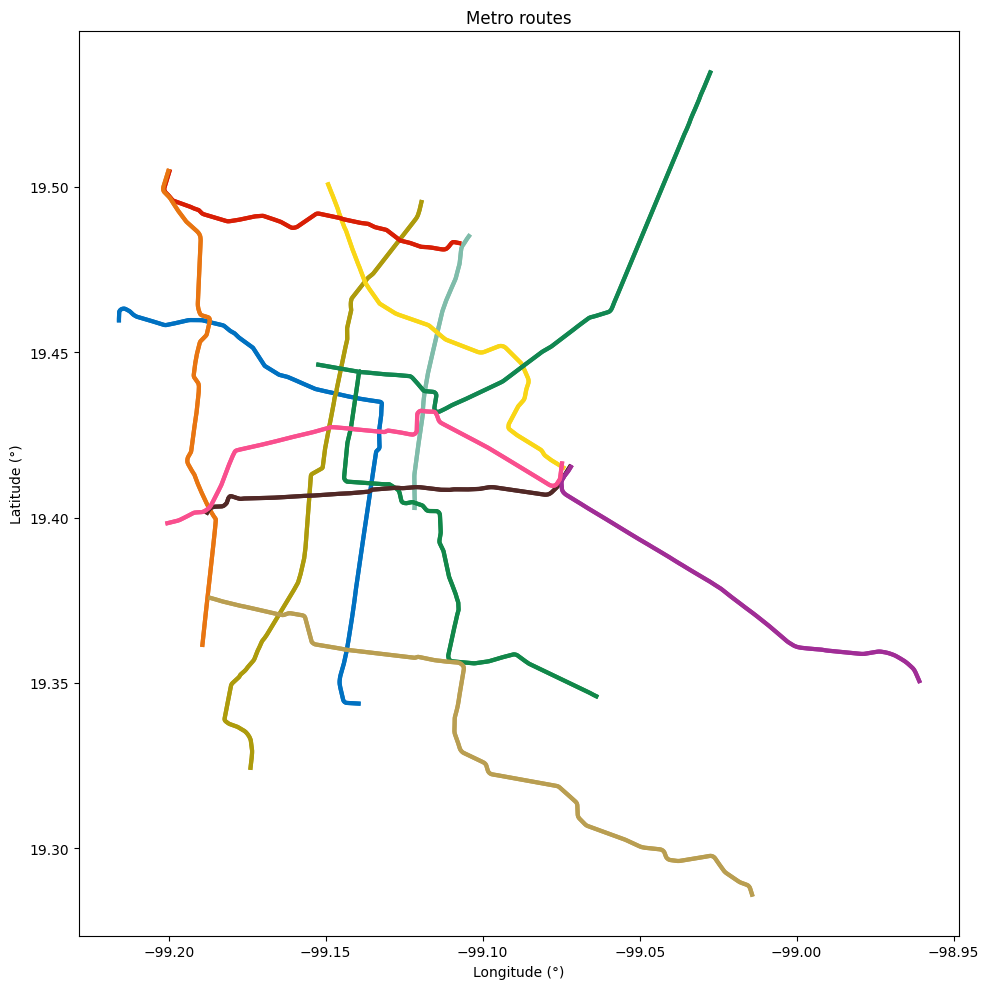

In [9]:
FigureRoutes = plt.figure(1, figsize=(10,10))
SubplotRoutes = FigureRoutes.add_subplot(111)

for shape_id in df_metro_shapes["shape_id"].unique():
    shape_dat = df_metro_shapes[df_metro_shapes["shape_id"] == shape_id]

    SubplotRoutes.plot(shape_dat["shape_pt_lon"], shape_dat["shape_pt_lat"], 
                       color = dict_metro_shapeid_colors[shape_id],
                       linewidth = 3, zorder = 0)
               
SubplotRoutes.set_xlabel("Longitude (°)")
SubplotRoutes.set_ylabel("Latitude (°)")
SubplotRoutes.set_title("Metro routes")

FigureRoutes.tight_layout()

## Filtrando ```stop_times.txt```

Capturamos los datos de tiempos de paradas asociados a las rutas del metro

In [10]:
list_metro_stoptimes = df_metro_trips["trip_id"].to_list()
index_metro_stoptimes = dataframes["stop_times"].isin(list_metro_stoptimes).any(axis = 1)

df_metro_stoptimes = dataframes["stop_times"][index_metro_stoptimes].reset_index().drop(labels = "index", axis = 1)
df_metro_stoptimes.to_csv("../output_metro/stop_times_metro.csv", index = False)
df_metro_stoptimes

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,timepoint
0,02100L1000_0,00:00:00,00:00:00,0200L1-OBSERVATORIO,1,0
1,02100L1000_0,00:02:50,00:02:50,0200L1-TACUBAYA,2,0
2,02100L1000_0,00:05:24,00:05:24,0200L1-JUANACATLAN,3,0
3,02100L1000_0,00:07:36,00:07:36,0200L1-CHAPULTEPEC,4,0
4,02100L1000_0,00:08:43,00:08:43,0200L1-SEVILLA,5,0
...,...,...,...,...,...,...
1165,0230L12000_1,00:47:38,00:47:38,020L12-PARQUEVENADOS,16,0
1166,0230L12000_1,00:49:18,00:49:18,020L12-ZAPATA,17,0
1167,0230L12000_1,00:50:35,00:50:35,020L12-HOSPITAL20,18,0
1168,0230L12000_1,00:52:23,00:52:23,020L12-INSURGENTESSUR,19,0


## Filtrando ```stops.txt```

Dados los tiempos de las paradas exclusivas del sistema metro, se capturan los ```stop_id``` de cada parada presente

In [11]:
metro_id_stations = list(df_metro_stoptimes["stop_id"].unique())
index_metro_stations = dataframes["stops"].isin(metro_id_stations).any(axis = 1)

df_metro_stops = dataframes["stops"][index_metro_stations].reset_index().drop(labels = "index", axis = 1)

stop_times_trips_merged = df_metro_stoptimes.merge(df_metro_trips[['trip_id', 'route_id']], on='trip_id')

stop_to_route_df = stop_times_trips_merged.merge(df_metro_stops[['stop_id']], on='stop_id')[["stop_id", "route_id"]].drop_duplicates()
df_metro_stops = pd.merge(df_metro_stops, stop_to_route_df, on = "stop_id", how = "left")
df_metro_stops = pd.merge(df_metro_stops, df_metro_routeid_colors, on = "route_id", how = "left")

df_metro_stops.to_csv("../output_metro/stops_metro.csv", index = False)
df_metro_stops

,stop_id,stop_name,stop_lat,stop_lon,zone_id,wheelchair_boarding,route_id,route_color
0,020L12-TLAHUAC,Tláhuac,19.28602,-99.01420,020L12-TLAHUAC,1,CMX020L12,B99E51
1,020L12-TLALTENCO,Tlaltenco,19.29435,-99.02403,020L12-TLALTENCO,1,CMX020L12,B99E51
2,020L12-ZAPOTITLAN,Zapotitlán,19.29666,-99.03431,020L12-ZAPOTITLAN,1,CMX020L12,B99E51
3,020L12-NOPALERA,Nopalera,19.29996,-99.04599,020L12-NOPALERA,1,CMX020L12,B99E51
4,020L12-OLIVOS,Olivos,19.30432,-99.05951,020L12-OLIVOS,1,CMX020L12,B99E51
...,...,...,...,...,...,...,...,...
190,0200L1-SEVILLA,Sevilla,19.42185,-99.17112,0200L1-SEVILLA,1,CMX0200L1,F94F8E
191,0200L1-CHAPULTEPEC,Chapultepec,19.42075,-99.17642,0200L1-CHAPULTEPEC,2,CMX0200L1,F94F8E
192,0200L1-JUANACATLAN,Juanacatlán,19.41295,-99.18198,0200L1-JUANACATLAN,2,CMX0200L1,F94F8E
193,0200L1-TACUBAYA,Tacubaya,19.40251,-99.18764,0200L1-TACUBAYA,2,CMX0200L1,F94F8E


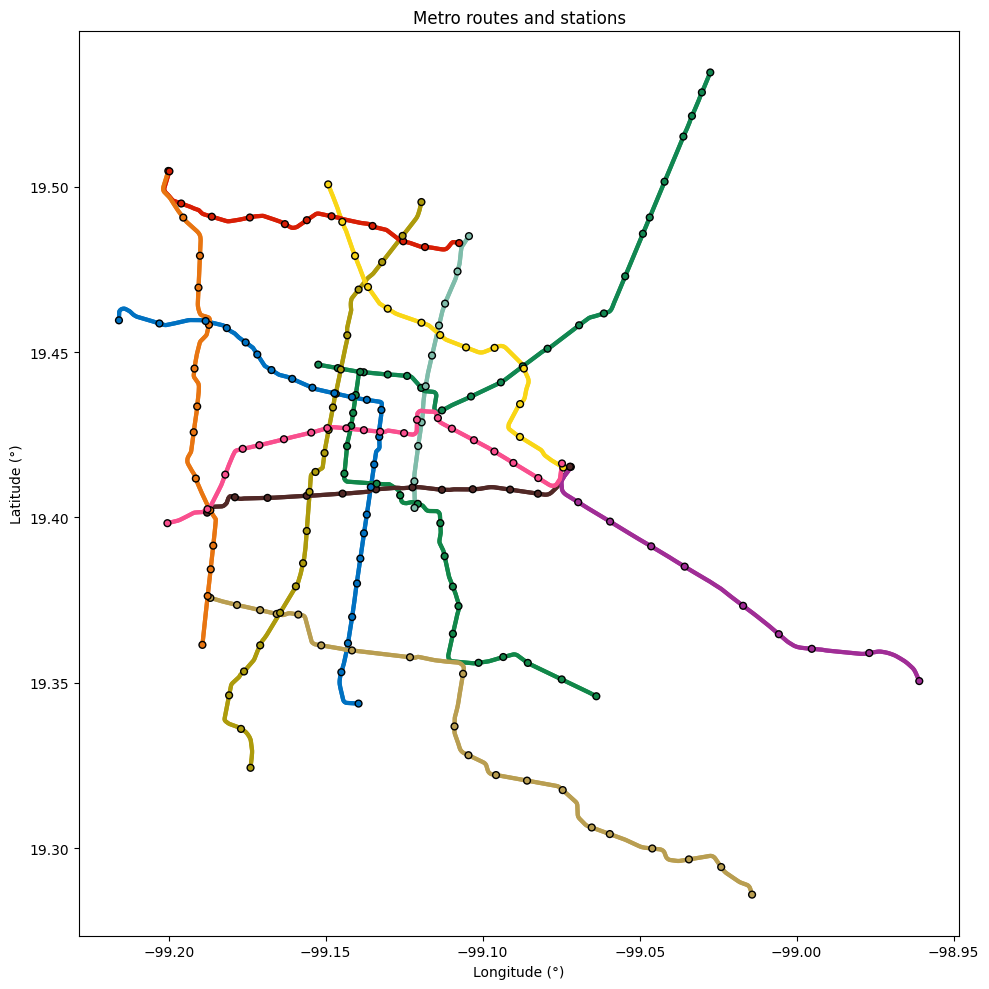

In [12]:
FigureRoutesStations = plt.figure(2, figsize=(10,10))
SubplotRoutesStations = FigureRoutesStations.add_subplot(111)

for shape_id in df_metro_shapes["shape_id"].unique():
    shape_dat = df_metro_shapes[df_metro_shapes["shape_id"] == shape_id]

    SubplotRoutesStations.plot(shape_dat["shape_pt_lon"], shape_dat["shape_pt_lat"], 
                       color = dict_metro_shapeid_colors[shape_id],
                       linewidth = 3, zorder = 0)

SubplotRoutesStations.set_xlabel("Longitude (°)")
SubplotRoutesStations.set_ylabel("Latitude (°)")
SubplotRoutesStations.set_title("Metro routes and stations")

SubplotRoutesStations.scatter(df_metro_stops["stop_lon"], df_metro_stops["stop_lat"], 
                              s = 24, c = list(map(lambda x: "#" + x, df_metro_stops["route_color"])),
                              edgecolors="black")

FigureRoutesStations.tight_layout()

## Filtrando ```frequencies.txt```

Y finalmente, se filtran los datos de las frecuencias dadas las etiquetas de los viajes registrados

In [13]:
metro_trips_id = list(df_metro_trips["trip_id"].unique())

index_metro_frequencies = dataframes["frequencies"].isin(metro_trips_id).any(axis = 1)
df_metro_frequencies = dataframes["frequencies"][index_metro_frequencies].reset_index().drop(labels = "index", axis = 1)
df_metro_frequencies.to_csv("../output_metro/frequencies_metro.csv", index = False)
df_metro_frequencies

,trip_id,start_time,end_time,headway_secs,exact_times
0,02300LB000_1,7:00:00,24:00:00,180,0
1,02300LB000_0,7:00:00,24:00:00,180,0
2,02200LB000_1,6:00:00,24:00:00,180,0
3,02200LB000_0,6:00:00,24:00:00,180,0
4,02100LB000_1,5:00:00,24:00:00,180,0
...,...,...,...,...,...
67,02300L1000_0,7:00:00,24:00:00,240,0
68,02200L1000_1,6:00:00,24:00:00,240,0
69,02200L1000_0,6:00:00,24:00:00,240,0
70,02100L1000_1,5:00:00,24:00:00,240,0
